# Разведочный анализ данных и построение первых моделей

## Импорты

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

In [2]:
import os
import sys

sys.path += [os.path.abspath("..")]
import pandas as pd
import functions.unifyer as uf

## Загрузка файла, общая информация

In [3]:
f1 = pd.read_csv("../data/existing_datasets/final_df.csv")
f2 = pd.read_csv("../final_p2.2.csv")
f1 = f1[f2.columns]
print(f1.shape, f2.shape)

(1130, 43) (2200, 43)


In [4]:
s2 = pd.read_csv("../start_p2.csv")
condition = (s2["formula"].apply(uf.is_valid_formula) * \
             (f2[["X", "IR", "pot2"]].isna().sum(axis=1) != 3) * \
              s2[["formula", "activity"]].notna().sum(axis=1) == 2)
f2 = f2[condition]
print(f2.shape)

(2187, 43)


In [5]:
df = pd.concat([f1.fillna(0), f2.fillna(0)], ignore_index=True)
df = df.drop(columns=["id"])
df.shape, df.index

((3317, 42), RangeIndex(start=0, stop=3317, step=1))

## Предобработка данных

In [6]:
# Удаляем дубликаты
df_final = df.drop_duplicates()
print(f'Кол-во дубликатов: {df_final.duplicated().sum()}\n')

Кол-во дубликатов: 0



In [7]:
# Определяем некорректные значения для преобразования в float
invalid_values = list(df_final['Km'][~df_final['Km'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()])
print(len(invalid_values))
print(set(invalid_values))

10
{'no'}


In [8]:
# Определяем некорректные значения для преобразования в float
invalid_values = list(df_final['Vmax'][~df_final['Vmax'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()])
print(len(invalid_values))
print(set(invalid_values))

71
{'no'}


In [9]:
# Определяем некорректные значения для преобразования в float
invalid_values = list(df_final['ph'][~df_final['ph'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()])
print(len(invalid_values))
print(set(invalid_values))

87
{'~7', '~3', '25 mM citric acid buffer', '5 mM', '4-12', '7.0 - 11.0', '6.5 - 10.5', '3-6.5', '5-10', '3-7.4', '3-7', '3.54 - 6.4', '2-11', '4 units', '4-9', '1.9-10.2', '7-8', '2-8', '~6.5-7.0', '4.0 - 6.0', '3 - 10', '4.0 - 5.6', '6-10', '5.0-7.0', '4.5-9.05', '3-6', '3-10', '4 mM', '~7.4', '5.2 ± 0.2', '8 ± 0.2'}


In [10]:
# Преобразование типов и замена "no" на NaN
df_final['Vmax'] = pd.to_numeric(df_final['Vmax'].replace("no", np.nan), errors='coerce')
df_final['Km'] = pd.to_numeric(df_final['Km'].replace("no", np.nan), errors='coerce')
df_final['ph'] = pd.to_numeric(df_final['ph'].where(lambda ph: ~ph.isin(invalid_values)), errors='coerce')
df_final['activity'] = df_final['activity'].replace({1: "peroxidase", 2: "oxidase", 3: "catalase", 4: "laccase"})
# Проверка результата
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3161 entries, 0 to 3316
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Km                  3151 non-null   float64
 1   Vmax                3090 non-null   float64
 2   activity            3161 non-null   object 
 3   X                   3161 non-null   float64
 4   IR                  3161 non-null   float64
 5   pot2                3161 non-null   float64
 6   ph                  3074 non-null   float64
 7   temp                3161 non-null   float64
 8   dstr                3161 non-null   float64
 9   lgCmin              3161 non-null   float64
 10  lgCmax              3161 non-null   float64
 11  Cmin                3161 non-null   float64
 12  Cmax                3161 non-null   float64
 13  lgCconst            3161 non-null   float64
 14  Cconst              3161 non-null   float64
 15  lgCcat              3161 non-null   float64
 16  Ccat       

/tmp/ipykernel_27209/2307407418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Vmax'] = pd.to_numeric(df_final['Vmax'].replace("no", np.nan), errors='coerce')
/tmp/ipykernel_27209/2307407418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Km'] = pd.to_numeric(df_final['Km'].replace("no", np.nan), errors='coerce')
/tmp/ipykernel_27209/2307407418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [11]:
category2num = {cat: i+1 for i, cat in enumerate(df_final['activity'].value_counts().index.tolist())}
category2num

{'peroxidase': 1,
 'oxidase': 2,
 'catalase': 3,
 'superoxide dismutase': 4,
 'phosphatase': 5,
 'multi-activity': 6,
 'esterase': 7,
 'laccase': 8,
 'glycosidase': 9,
 'reductase': 10,
 'uricase': 11,
 'dnase': 12,
 'rnase': 13,
 'hydrolase': 14,
 'phosphotriesterase': 15,
 'epoxydase': 16}

In [12]:
df_final['activity'] = df_final['activity'].replace(category2num)

/tmp/ipykernel_27209/3523156907.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['activity'] = df_final['activity'].replace(category2num)
/tmp/ipykernel_27209/3523156907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['activity'] = df_final['activity'].replace(category2num)


In [15]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3161 entries, 0 to 3316
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Km                  3151 non-null   float64
 1   Vmax                3090 non-null   float64
 2   activity            3161 non-null   int64  
 3   X                   3161 non-null   float64
 4   IR                  3161 non-null   float64
 5   pot2                3161 non-null   float64
 6   ph                  3074 non-null   float64
 7   temp                3161 non-null   float64
 8   dstr                3161 non-null   float64
 9   lgCmin              3161 non-null   float64
 10  lgCmax              3161 non-null   float64
 11  Cmin                3161 non-null   float64
 12  Cmax                3161 non-null   float64
 13  lgCconst            3161 non-null   float64
 14  Cconst              3161 non-null   float64
 15  lgCcat              3161 non-null   float64
 16  Ccat       

## Исследовательский анализ

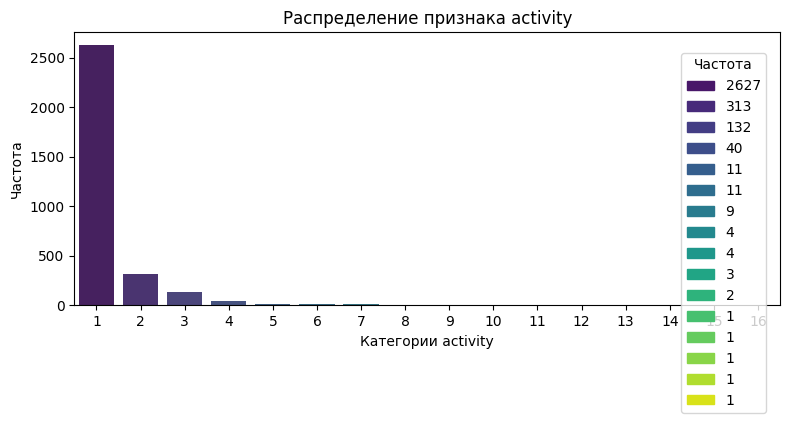

In [16]:
# Подсчёт количества элементов для каждой категории
activity_counts = df_final['activity'].value_counts()

# Создание палитры с разными цветами для категорий
palette = sns.color_palette('viridis', len(activity_counts))

# Построение countplot с разными цветами для каждой категории
plt.figure(figsize=(8, 4))
sns.countplot(x='activity', data=df_final, hue='activity', palette=palette, dodge=False, legend=False)

# Добавление легенды с количеством элементов
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(activity_counts))]
labels = [f"{count}" for count in activity_counts.values]
plt.legend(handles, labels, title="Частота", bbox_to_anchor=(0.85, 0.95), loc='upper left')

# Настройка графика
plt.title('Распределение признака activity')
plt.xlabel('Категории activity')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

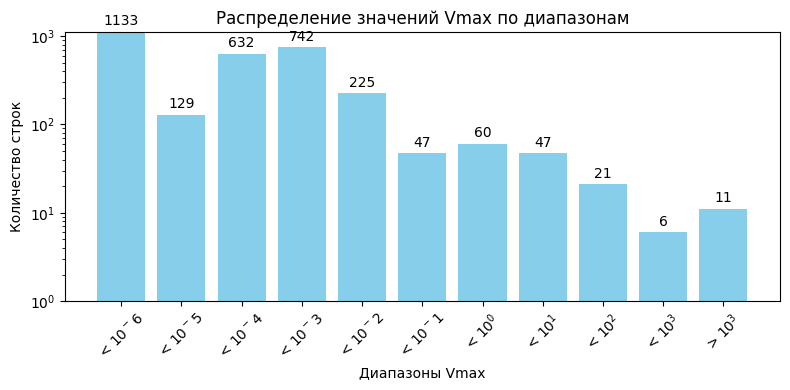

In [16]:
# Определяем диапазоны
bins = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, float('inf')]
labels = ['< $10^-6$', '< $10^-5$', '< $10^-4$', '< $10^-3$', '< $10^-2$', '< $10^-1$', '< $10^0$', '< $10^1$', '< $10^2$', '< $10^3$' , '> $10^3$']

# Подсчёт количества строк в каждом диапазоне
df_final['range'] = pd.cut(df_final['Vmax'], bins=bins, labels=labels, include_lowest=True)
counts = df_final['range'].value_counts(sort=False)

# Построение диаграммы
plt.figure(figsize=(8, 4))
bars = plt.bar(labels, counts, color='skyblue')
plt.title('Распределение значений Vmax по диапазонам')
plt.xlabel('Диапазоны Vmax')
plt.ylabel('Количество строк')

# Добавление подписей на графике с одинаковым расстоянием
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.1, str(count), 
             ha='center', va='bottom', fontsize=10)

# Настройка логарифмической шкалы на оси Y и фиксирование максимума
plt.yscale('log')
plt.ylim(1, 1100)

# Указываем степени 10 на оси Y
plt.gca().yaxis.set_major_locator(plt.LogLocator(base=10.0))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$" if x > 0 else ""))

# Убираем угол поворота подписей на оси X
plt.xticks(rotation=45)

# Настройка отображения
plt.tight_layout()
plt.show()

# Удаляем вспомогательную колонку
df_final = df_final.drop(columns='range')

## Корреляционный анализ

In [17]:
# Укажите явные интервальные столбцы
interval_cols = df_final.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Вычисление корреляционной матрицы Phik
phik_corr = df_final.phik_matrix(interval_cols=interval_cols)

/home/oleg/Programs/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/oleg/Programs/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:172: RuntimeWarning: invalid value encountered in add
  y += start
/home/oleg/Programs/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/oleg/Programs/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:172: RuntimeWarning: invalid value encountered in add
  y += start
/home/oleg/Programs/.venv/lib/python3.12/site-packages/phik/phik.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_binned.replace(defs.UF, np.nan, 

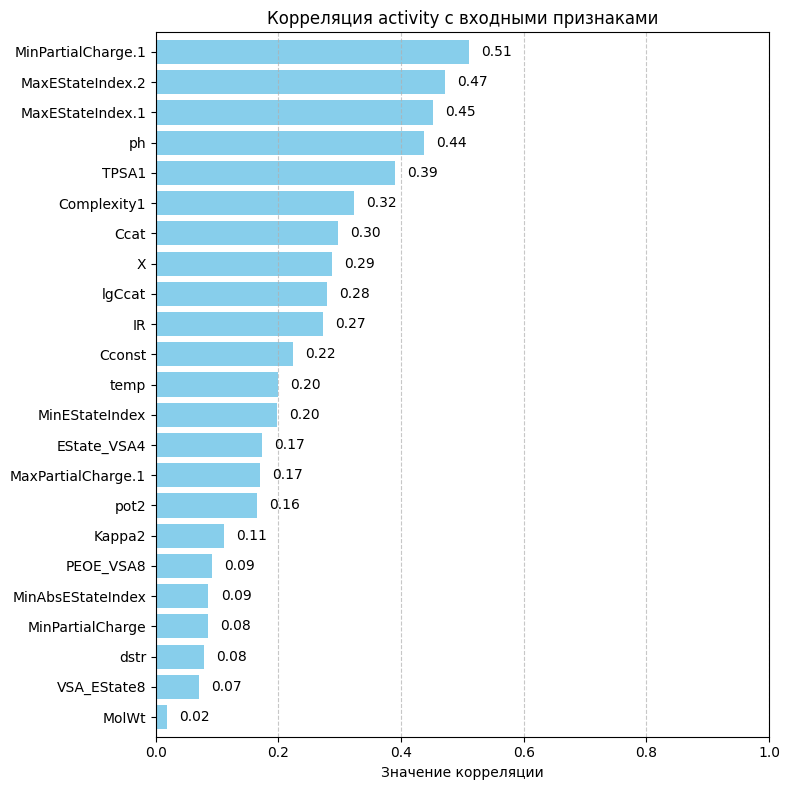

In [18]:
# Фильтрация значений из столбца 'activity' в диапазоне (0, 1)
vmax_corr = phik_corr['activity'][(phik_corr['activity'] > 0) & (phik_corr['activity'] < 1)].sort_values()

# Построение горизонтальной диаграммы
plt.figure(figsize=(8, 8))
bars = vmax_corr.plot(kind='barh', color='skyblue', width=0.8)
plt.title('Корреляция activity с входными признаками')
plt.xlabel('Значение корреляции')
plt.ylabel('')

# Настройка оси X и сетки
plt.xlim(0, 1)  # Фиксируем диапазон оси X от 0 до 1
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавляем вертикальную сетку

# Добавление подписей на график
for index, value in enumerate(vmax_corr):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center')

# Отображение
plt.tight_layout()
plt.show()

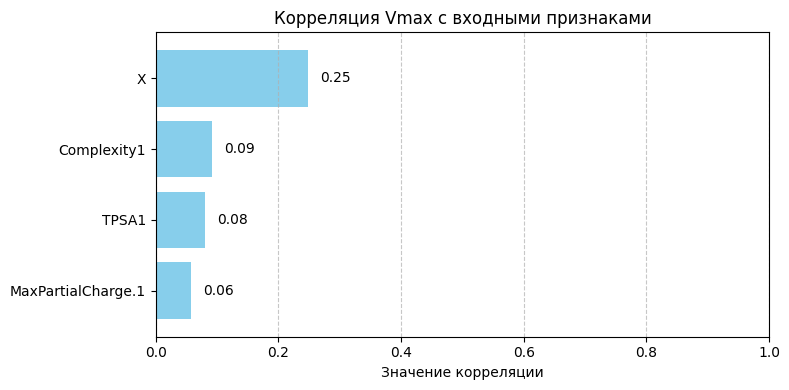

In [15]:
# Фильтрация значений из столбца 'Vmax' в диапазоне (0, 1)
vmax_corr = phik_corr['Vmax'][(phik_corr['Vmax'] > 0) & (phik_corr['Vmax'] < 1)].sort_values()

# Построение горизонтальной диаграммы
plt.figure(figsize=(8, 4))
bars = vmax_corr.plot(kind='barh', color='skyblue', width=0.8)
plt.title('Корреляция Vmax с входными признаками')
plt.xlabel('Значение корреляции')
plt.ylabel('')

# Настройка оси X и сетки
plt.xlim(0, 1)  # Фиксируем диапазон оси X от 0 до 1
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавляем вертикальную сетку

# Добавление подписей на график
for index, value in enumerate(vmax_corr):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center')

# Отображение
plt.tight_layout()
plt.show()

In [19]:
vmax_corr.index

Index(['MolWt', 'VSA_EState8', 'dstr', 'MinPartialCharge', 'MinAbsEStateIndex',
       'PEOE_VSA8', 'Kappa2', 'pot2', 'MaxPartialCharge.1', 'EState_VSA4',
       'MinEStateIndex', 'temp', 'Cconst', 'IR', 'lgCcat', 'X', 'Ccat',
       'Complexity1', 'TPSA1', 'ph', 'MaxEStateIndex.1', 'MaxEStateIndex.2',
       'MinPartialCharge.1'],
      dtype='object')

In [20]:
# Сохраняем входные признаки, которые коррелируют с целевыми
corr_with_vmax = [
    "lgCcat", "BalabanJ", "Cconst", "BCUT2D_CHGLO", "lgCconst", "lgvolume", "lgCmin", "Sufrace", "activity"
]
corr_with_activity = [
    'MolWt', 'VSA_EState8', 'dstr', 'MinPartialCharge', 'MinAbsEStateIndex',
    'PEOE_VSA8', 'Kappa2', 'pot2', 'MaxPartialCharge.1', 'EState_VSA4',
    'MinEStateIndex', 'temp', 'Cconst', 'IR', 'lgCcat', 'X', 'Ccat',
    'Complexity1', 'TPSA1', 'ph', 'MaxEStateIndex.1', 'MaxEStateIndex.2',
    'MinPartialCharge.1'
]

### Сохраняем списки коррелирующими признаками в файлы

In [21]:
# Сохранение списков в файлы
with open("corr_with_vmax.txt", "w") as file_vmax:
    file_vmax.write("\n".join(corr_with_vmax))
with open("corr_with_activity2.2.txt", "w") as file_activity:
    file_activity.write("\n".join(corr_with_activity))
    
# Проверка, что файлы сохранены
if os.path.exists("corr_with_vmax.txt"):
    print("Файл 'corr_with_vmax.txt' успешно сохранен.")
else:
    print("Ошибка: файл 'corr_with_vmax.txt' не сохранен.")

if os.path.exists("corr_with_activity.txt"):
    print("Файл 'corr_with_activity.txt' успешно сохранен.")
else:
    print("Ошибка: файл 'corr_with_activity.txt' не сохранен.")

Файл 'corr_with_vmax.txt' успешно сохранен.
Файл 'corr_with_activity.txt' успешно сохранен.
